In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import os
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt  
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

/home/karine/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karine/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karine/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Exploring and cleaning the data

In [2]:
train = pd.read_csv('train-set.csv')
test  = pd.read_csv('test-set.csv')
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2611,326,20,120,27,1597,168,214,184,...,0,0,0,0,0,0,0,0,0,6
1,2,2772,324,17,42,7,1814,175,220,183,...,0,0,0,0,0,0,0,0,0,2
2,3,2764,4,14,480,-21,700,201,212,148,...,0,0,0,0,0,0,0,0,0,2
3,4,3032,342,9,60,8,4050,202,227,164,...,0,0,0,0,0,0,0,0,0,2
4,5,2488,23,11,117,21,1117,209,218,151,...,0,0,0,0,0,0,0,0,0,2


After having verified there is no Nan values and that the data is cleaned, which is the case here, we can begin our first step.
The first step to do a machine learning project is to look at the covariates and see how they correlate between 
each other, their influence on the target we want to predict. It is also important to have some knowledge of the domain in order to create other features which are relevant for predicting our target.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05848c32b0>,
      dtype=object)

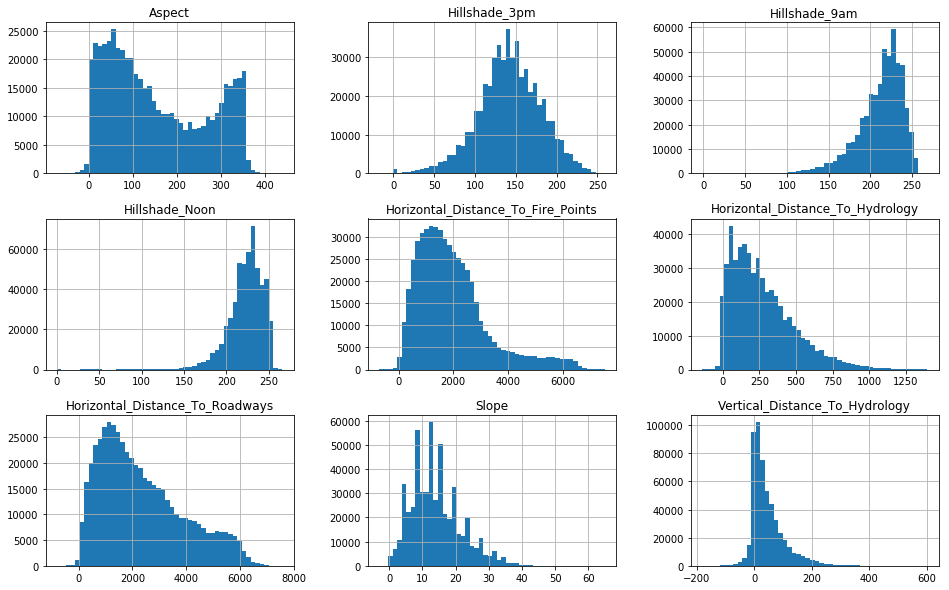

In [3]:
train.iloc[:,2:11].hist(figsize=(16,10), bins=50) 

By looking the distribution of the features, we can see that some of them as the Horizontal_Distance_To_Hydrology can be transformed to have more gaussian shape. We will look at that case below.

# Creating new features (feature engineering)

I am convinced that the creation of new features, transformation of the data 
will have a stronger impact on the result than the choise of the evaluator

## Distance to Hydrology

In this subsection, I am creating new features which are more correlated to the Cover_Type.

In [5]:
dist_to_water = train.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)
dist_to_water_test = test.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)

train['dist_to_water'] = train.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)
test['dist_to_water_test'] = test.loc[:, ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2), axis=1)


train['mean_hillshade'] =  np.mean(train['Hillshade_9am']  + train['Hillshade_Noon'] + train['Hillshade_3pm'] )

test['mean_hillshade'] =  np.mean(test['Hillshade_9am']  + test['Hillshade_Noon'] + test['Hillshade_3pm'] )


## Linear relation between the different categorical features 

In this subsection, I am creating vectors which are the linear relation between the different categorical features.

In [6]:

#Code from http://www.filipyoo.com/learn-data-science-with-kaggle-using-python/

def categorize(df, cols_name):
    for k in range(df.shape[1]):
        df[cols_name+str(k+1)] = df.loc[:, cols_name+str(k+1)].map({1:k+1, 0:0})
    return df

wilderness = train.loc[:, 'Wilderness_Area1': 'Wilderness_Area4']
wilderness = categorize(wilderness, 'Wilderness_Area')
wilderness = wilderness.sum(axis=1).astype('category')

train['wilderness']=wilderness 

wilderness_test = test.loc[:, 'Wilderness_Area1': 'Wilderness_Area4']
wilderness_test = categorize(wilderness_test, 'Wilderness_Area')
wilderness_test = wilderness_test.sum(axis=1).astype('category')
test['wilderness_test']=wilderness_test
#test = pd.concat([test, wilderness_test], axis=1)


# categorize the 40 columns of Soil_Type into 1 single column 
soil = train.loc[:, 'Soil_Type1': 'Soil_Type40']
soil = categorize(soil, 'Soil_Type')
soil = soil.sum(axis=1).astype('category')
soil = pd.DataFrame(soil, columns=['soil'])
train['soil']=soil 

soil_test = test.loc[:, 'Soil_Type1': 'Soil_Type40']
soil_test = categorize(soil_test, 'Soil_Type')
soil_test = soil_test.sum(axis=1).astype('category')
soil_test = pd.DataFrame(soil_test, columns=['soil_test'])
test['soil_test']=soil_test

## Hillshade mean

In [7]:
train['mean_hillshade'] =  np.mean(train['Hillshade_9am']  + train['Hillshade_Noon'] + train['Hillshade_3pm'] )
test['mean_hillshade'] =  np.mean(test['Hillshade_9am']  + test['Hillshade_Noon'] + test['Hillshade_3pm'] )

## Vertical distance in absolute put a worse result 


In [8]:
train['Horizontal_Distance_To_Fire_Points']=np.abs(train['Horizontal_Distance_To_Fire_Points'])
test['Horizontal_Distance_To_Fire_Points']=np.abs(test['Horizontal_Distance_To_Fire_Points'])
train['Horizontal_Distance_To_Hydrology_abs']=np.abs(train['Horizontal_Distance_To_Hydrology'])
test['Horizontal_Distance_To_Hydrology_abs']=np.abs(test['Horizontal_Distance_To_Hydrology'])

train['Vertical_Distance_To_Hydrology_abs']=np.abs(train['Vertical_Distance_To_Hydrology'])
test['Vertical_Distance_To_Hydrology_abs']=np.abs(test['Vertical_Distance_To_Hydrology'])

I finally kept the original data, which was giving a better result.

## Transforming the data in order to get a gaussian distribution

### Horizontal distance to hydrology

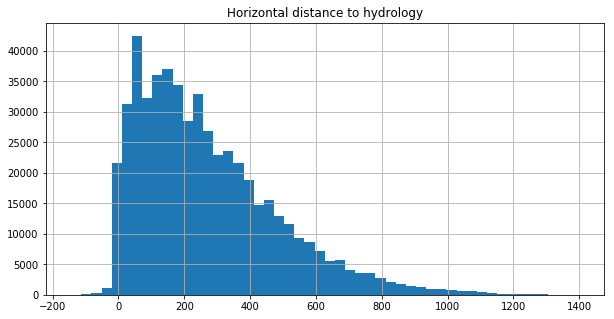

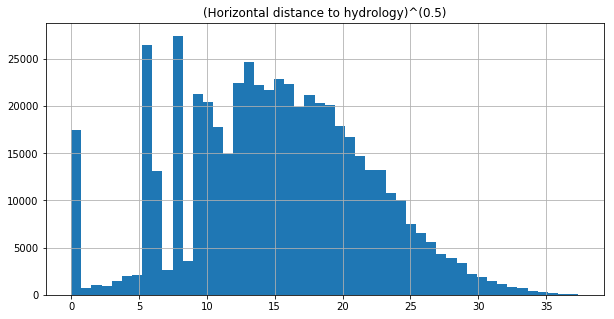

In [9]:
plt.figure(figsize=(10,5))
train.iloc[:,4].hist(bins=50) 
plt.title('Horizontal distance to hydrology')
plt.figure(figsize=(10,5))
plt.title('(Horizontal distance to hydrology)^(0.5)')
np.sqrt(np.abs(train.iloc[:,4])).hist( bins=50) 


### Horizontal distance to roadways

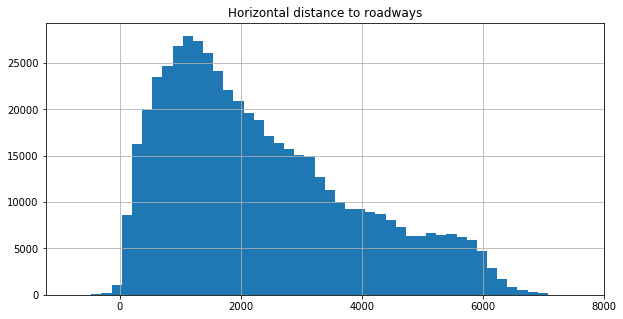

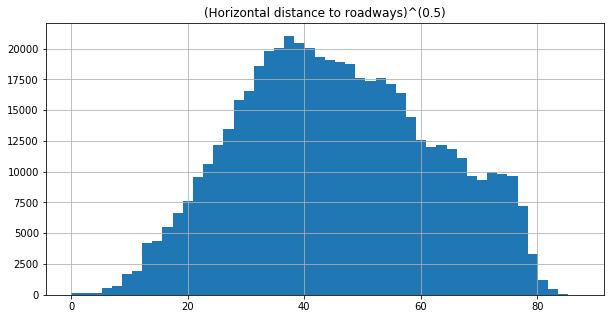

In [10]:
plt.figure(figsize=(10,5))
train.iloc[:,6].hist(bins=50) 
plt.title('Horizontal distance to roadways')
plt.figure(figsize=(10,5))
plt.title('(Horizontal distance to roadways)^(0.5)')
np.sqrt(np.abs(train.iloc[:,6])).hist( bins=50) 

It was a try but did not improve the results.

In [11]:
train['Horizontal_Distance_To_Roadways_sq']=np.sqrt(np.abs(train['Horizontal_Distance_To_Roadways']))
test['Horizontal_Distance_To_Roadways_sq']=np.sqrt(np.abs(test['Horizontal_Distance_To_Roadways']))
train['Horizontal_Distance_To_Hydrology_sq']=np.sqrt(np.abs(train['Horizontal_Distance_To_Hydrology']))
test['Horizontal_Distance_To_Hydrology_sq']=np.sqrt(np.abs(test['Horizontal_Distance_To_Hydrology']))

No better results with the transformation, therefore I have selected the features written below

In [12]:
X_for_corr= train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'dist_to_water', 'mean_hillshade', 'soil','wilderness','Cover_Type']]

# Looking the correlation between the features and their influence on the target: Cover_Type

In [13]:
X_corr_evaluate=train[['Cover_Type','Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Hydrology_sq','dist_to_water','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways_sq','Horizontal_Distance_To_Roadways']]

In [14]:
X_corr_evaluate.corr()

,Cover_Type,Horizontal_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology_sq,dist_to_water,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways_sq,Horizontal_Distance_To_Roadways
Cover_Type,1.000000,-0.021310,-0.030954,-0.015168,0.080418,-0.161486,-0.153450
Horizontal_Distance_To_Hydrology,-0.021310,1.000000,0.959196,0.998635,0.603901,0.068585,0.071222
Horizontal_Distance_To_Hydrology_sq,-0.030954,0.959196,1.000000,0.958626,0.583097,0.058183,0.063074
dist_to_water,-0.015168,0.998635,0.958626,1.000000,0.636130,0.060786,0.063538
Vertical_Distance_To_Hydrology,0.080418,0.603901,0.583097,0.636130,1.000000,-0.048280,-0.047297
Horizontal_Distance_To_Roadways_sq,-0.161486,0.068585,0.058183,0.060786,-0.048280,1.000000,0.980598
Horizontal_Distance_To_Roadways,-0.153450,0.071222,0.063074,0.063538,-0.047297,0.980598,1.000000


We can see there is more correlation between the cover type and the square of the 2 quantities
(Horizontal_Distance_To_Hydrology, Horizontal_Distance_To_Roadways). However it does not improve the results..

# Prepare the model

## Select the features which are more relevant to find the target

In [15]:
ID=test['Id']
X= train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'dist_to_water', 'mean_hillshade', 'soil','wilderness']]
y = train.Cover_Type
X_test= test[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology','dist_to_water_test', 'mean_hillshade', 'soil_test','wilderness_test']]

## Choice of the evaluator

The problem is a classification type. We want to predict labels. Therefore we need to use a classifier.
Besides our features (covariates) are strongly dependant from each other, and the problem is non linear.
Therefore one of the model which can handle this kind of issue, is the Random Forest Classifier.

## Use of cross-validation to find the optimal hyperparameters

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80],
    'max_features': [6],
    'min_samples_leaf': [2,4],
    'min_samples_split': [6, 10],
    'n_estimators': [200,300]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

grid_search.fit(X, y)

print (grid_search.best_estimator_)

submission = pd.read_csv('submission-example.csv')
submission['Id'] = ID
submission['Cover_Type'] = grid_search.fit(X, y).predict(X_test)
submission.to_csv('output_with_rf_morefeatures.csv', index = None)

However, it was taking too much time so I have taken manually hyperparameters and have tried different values.
I couldn't go higher than 300 estimators because of my computer power.

In [ ]:
param_grid = {
    'bootstrap': True,
    'max_depth': 80,
    'max_features': 6,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 300
}

# Create a based model
rf = RandomForestClassifier(n_estimators= 300, max_features= 4)
# Instantiate the grid search model
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                        #  cv = 10, n_jobs = -1, verbose = 2)

rf.fit(X, y)

#print (rf.best_estimator_)

submission = pd.read_csv('submission-example.csv')
submission['Id'] = ID
submission['Cover_Type'] =rf.fit(X, y).predict(X_test)
submission.to_csv('output_with_rf_morefeatures.csv', index = None)

In sklearn there is another evaluator ExtraTreesClassifier which have given me a little bit better results
than the random forest.
The ExtraTreesClassifier is a "meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting". (from the doc of scikit learn).
As it improves the predictive accuracy, we can hope to have a better score with it than Random Forest or Decision Tree. It gives better results when the features are a little bit noisy.

In [ ]:
#the number of features is supposed to be the square of the number of features in classification so
#here between 4 and 3. However I used 6 in order to reduce computation power.

xb=ExtraTreesClassifier(n_estimators= 300, max_features= 6)
xb.fit(X, y)

#print (xb.best_estimator_)

submission = pd.read_csv('submission-example.csv')
submission['Id'] = ID
submission['Cover_Type'] =xb.fit(X, y).predict(X_test)
submission.to_csv('output_with_xb_morefeaturesmoref310_auto_feature2.csv', index = None)

I also try other evaluators, by using different parameters, in order to look at the difference.
However I haven't had enough computation power. Moreover I still convince that the best thing to get a better score, is more the use of relevant features than the evaluator.

### Try AdaBoostClassifier with different hyperparameters

In [ ]:
xb=AdaBoostClassifier(base_estimator=None, n_estimators=320, learning_rate=0.02, random_state=None)
xb.fit(X, y)

#print (rf.best_estimator_)

submission = pd.read_csv('submission-example.csv')
submission['Id'] = ID
submission['Cover_Type'] =xb.fit(X, y).predict(X_test)
submission.to_csv('output_with_adaboostg_morefeatures.csv', index = None)


# Conclusion

I got the best results with the ExtraTreesClassifier (which was a little bit better than the Random Forest Classifier).
In order to have better result, I would have done a "grid search" (n cross validation) over a fine grid to get the optimal hyperparameters. However it requests a lot of computing power..